In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from bs4 import BeautifulSoup as bs
import pickle
import re
from matplotlib import pyplot as plt
import ImprovedOSMToGraph as mkgraph
import xml.sax
import copy
import networkx

In [2]:
seattle = pd.read_csv("Seattle_Traffic_Incidents.csv",low_memory=False)
baton = pd.read_csv("Baton_Rouge_Traffic_Incidents.csv")
bloom = pd.read_csv("Bloomington_Traffic_Incidents.csv",encoding="ISO-8859-1")

# Removing Extraneous Data

In [3]:
seattle = seattle.drop(columns=["OBJECTID", "INCKEY", "COLDETKEY", "REPORTNO", "STATUS", "INTKEY", "EXCEPTRSNCODE","EXCEPTRSNDESC","COLLISIONTYPE","SDOT_COLCODE","SDOTCOLNUM","PEDROWNOTGRNT","ST_COLCODE","ST_COLDESC","SEGLANEKEY","CROSSWALKKEY", "LOCATION","ADDRTYPE","SEVERITYCODE","PERSONCOUNT","SEVERITYDESC","PEDCOUNT","PEDCYLCOUNT","VEHCOUNT","JUNCTIONTYPE","SDOT_COLDESC","INATTENTIONIND","UNDERINFL","WEATHER","ROADCOND","LIGHTCOND","SPEEDING","HITPARKEDCAR"])
baton = baton.drop(columns=["TOT VEH","STREET TYPE", "FORMATTED STREET", "TRAIN INVOLVED", "PEDESTRIAN", "FILE#","DISTRICT","MANNER OF COLLISION", "SURFACE CONDITION", "SURFACE TYPE", "ROAD CONDITION", "ROAD TYPE", "WEATHER", "LIGHTING", "ZONE","SUBZONE","STREET#","STREET DIRECTION","STREET NAME", "HIT&RUN", "CLOSEST STREET", "ALIGNMENT", "PRIMARY FACTOR", "SECOND FACTOR","LOCATION KIND", "RELATION ROADWAY", "ACCESS CONTROL"])
bloom = bloom.drop(columns=["Master Record Number", "Primary Factor", "Reported_Location","Weekend?","Collision Type"])

In [4]:
seattle = seattle.rename(columns={"X":"LONGITUDE", "Y":"LATITUDE"})
bloom = bloom.rename(columns={"Latitude":"LATITUDE", "Longitude":"LONGITUDE"})
baton["LONGITUDE"] = np.nan
baton["LATITUDE"] = np.nan

### Resultant Columns

In [5]:
print("Seattle:\n", seattle.columns)
print("Baton Rouge:\n", baton.columns)
print("Bloomington:\n", bloom.columns)

Seattle:
 Index(['LONGITUDE', 'LATITUDE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES',
       'INCDATE', 'INCDTTM'],
      dtype='object')
Baton Rouge:
 Index(['CRASH DATE', 'CRASH TIME', 'OCCURED ON', 'FATALITY', 'INJURY',
       'AT INTERSECTION', 'GEOLOCATION', 'LONGITUDE', 'LATITUDE'],
      dtype='object')
Bloomington:
 Index(['Year', 'Month', 'Day', 'Hour', 'Injury Type', 'LATITUDE', 'LONGITUDE'], dtype='object')


# Cleaning Baton Rouge

Baton Rouge mainly just needed the extraction of the Latitude and Longitude from the GEOLOCATION column. A regular expression is used to extract the data, and NaNs in the data are then removed.

In [6]:
locs = baton["GEOLOCATION"]
print(locs[2])

700 E I10
BATON ROUGE, LA


In [7]:
#Develop regex expression for finding (LAT,LON), test it
print(len(locs))
find_tuple = re.compile(r"\(\d+.*")
find_lat = re.compile(r"-*\d+\.\d+")
find_lon = re.compile(r"\,\s-*\d+\.\d+")

tupee = find_tuple.search(locs[1]).group()
print("Tupee: ",tupee)
print("Lat: ",float(find_lat.search(tupee).group()))
print("Lon: ",float(find_lon.search(tupee).group()[2:]))



144202
Tupee:  (30.459057, -91.058129)
Lat:  30.459057
Lon:  -91.058129


In [8]:
print(len(baton["GEOLOCATION"]))

144202


In [9]:
#apply it

#Drop a specific bad datum
#baton = baton.

lats = []
lons = []
idx = 0
for geo in baton["GEOLOCATION"]:
    
    if(find_tuple.search(geo) is not None):
        tupee = find_tuple.search(geo).group()
        if tupee == "(500)": #the one case that needs to be handled separately.
            lats.append(np.nan)
            lons.append(np.nan)
        else:
            lat = float(find_lat.search(tupee).group())
            lon = float(find_lon.search(tupee).group()[2:])
            lats.append(lat)
            lons.append(lon)
    else:
        lats.append(np.nan)
        lons.append(np.nan)

        idx += 1
baton["LATITUDE"]= lats
baton["LONGITUDE"]=lons
baton = baton.dropna(subset=["LONGITUDE", "LATITUDE"])
#print(len(test_baton))

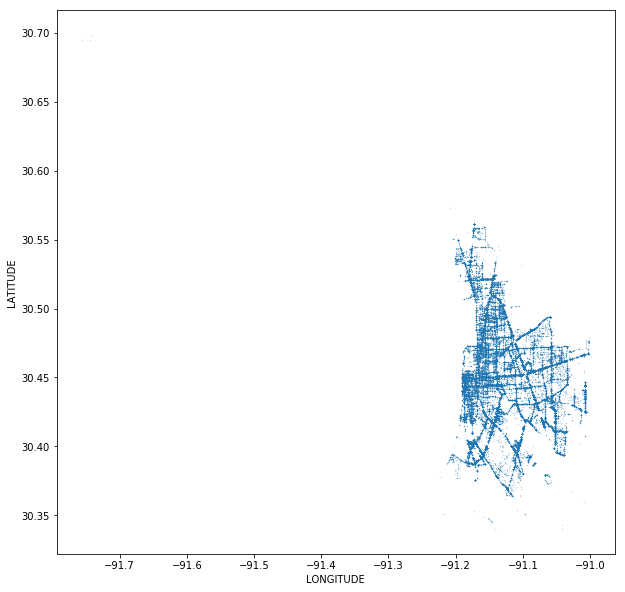

In [10]:
baton.plot(kind="scatter", x="LONGITUDE", y="LATITUDE", s=.01, figsize=(10,10))
plt.show()


In [11]:
baton = baton.drop(columns="GEOLOCATION")

# Cleaning Bloomington
Similarly to Baton Rouge, we removed the Nans. We also had to throw out crazy outliers.

In [14]:
la_lats =[]
la_lons =[]

bloom[bloom["LATITUDE"] > 40] = np.nan
bloom[bloom["LATITUDE"] < 38.9]= np.nan
bloom[bloom["LONGITUDE"] > -86] = np.nan
bloom[bloom["LONGITUDE"] < -87] = np.nan

bloom = bloom.dropna(subset=["LONGITUDE", "LATITUDE"])

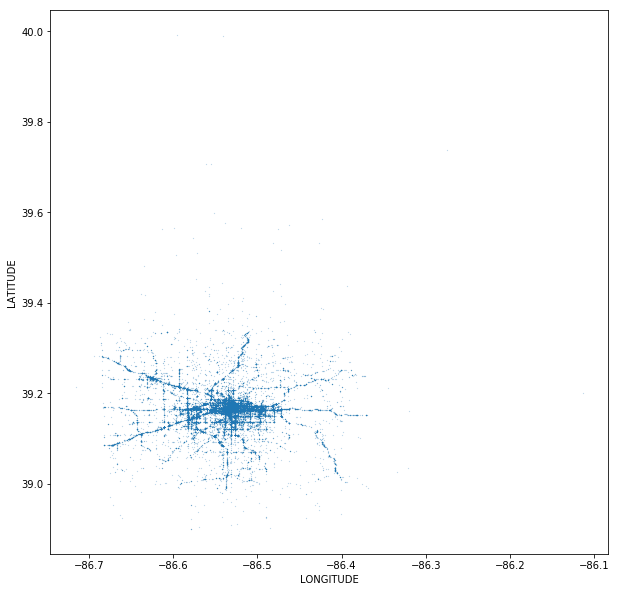

In [15]:
bloom.plot(kind="scatter", x="LONGITUDE", y="LATITUDE", s=.01,figsize=(10,10))
plt.show()


# Cleaning Seattle
Seattle just needed to have the NaNs removed, cause apparently the City of Seattle is awesome.

In [16]:
seattle = seattle.dropna(subset=["LATITUDE","LONGITUDE"])

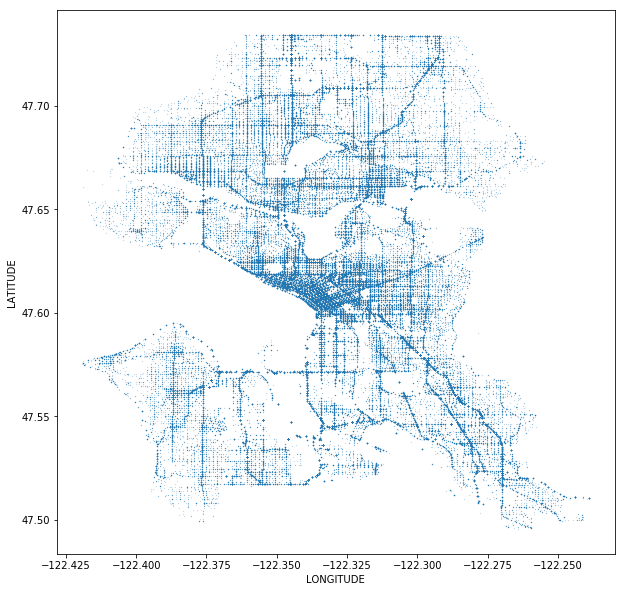

In [17]:
seattle.plot(kind="scatter", x="LONGITUDE", y="LATITUDE", s=.01, figsize=(10,10))
plt.show()

# Data Weaknesses

We feel pretty confident in the validity of our data. The collision data was gathered and reported by the respective city agencies in Seattle, Baton Rouge, and Los Angeles. While there were some entries with incomplete/bad data, the sheer amount of good data entries allowed us to simply remove the bad data and still have plenty of data. 
As mentioned, some data seemed wrong. When we graphed the lat/lon of the collisions recorded in each city, some were waaaayy off. We simply removed these outliers, and examining the remaining collisions via graph concluded that the remaining data was correct and sufficient.

One key data feature we were unable to collect was traffic flows of the cities in question. While disheartening, we think the data we still have will prove useful in answering our central question. Feature engineering will be key.



In [18]:
seattle.to_csv("Cleaned_Seattle.csv")
baton.to_csv("Cleaned_Baton.csv")
bloom.to_csv("Cleaned_Bloom.csv")

# Making City Graphs
We are going to categorize the types of roads that each of the accidents in our data happened on.  To do this we found downloaded data from OpenStreetMaps (https://www.openstreetmap.org/).  The format of this data is not easy to use, so we used a script we obtained from GitHub (https://gist.github.com/Tofull/49fbb9f3661e376d2fe08c2e9d64320e) that converts the data into a networkx graph (networkx is a Python package for building and representing graphs).  

In [3]:
#use the script to turn the XML files of OSM into Networkx graph objects
Seattle_Graph = mkgraph.read_osm("seattle_map")
Bloomington_Graph = mkgraph.read_osm("bloomington_map")
Baton_Rouge_Graph = mkgraph.read_osm("baton_rouge_map")

In [4]:
def save_graph(graph, output_file_name):
    """
    Saves the networkx [graph] as a pickle with name [output_file_name]
    Parameters: 
        graph: networkx graph object
        output_file_name: string
        
    """
    with open(output_file_name, 'wb') as to_save:
        pickle.dump(graph, to_save, pickle.HIGHEST_PROTOCOL)

def load_graph(filename):
    """
    Loads the pickled version of the graph at [filename]
    Parameter: 
        filename: location of the pickled networkx graph.
    
    Output: networkx graph at location [filename]
    """
    with open(filename, 'rb') as file:
        graph = pickle.load(file)
        
    return graph
        
save_graph(Seattle_Graph, "seattle_graph")
save_graph(Bloomington_Graph, "bloomington_graph")
save_graph(Baton_Rouge_Graph, "baton_rouge_graph")

Below are functions for graphing the networkX objects

In [ ]:
def get_positions(graph):
    return {n:(graph.node[n]['lon'], graph.node[n]['lat']) for i, n in enumerate(graph)}

In [ ]:
def draw_network(graph):
    networkx.draw_networkx(graph, get_positions(graph), with_labels=False, node_size=1)
    plt.show()

In [ ]:
networkx.draw_networkx(Seattle_Graph, get_positions(Seattle_Graph), with_labels=False, node_size=1)
plt.show()

In [ ]:
networkx.draw_networkx(Baton_Rouge_Graph, get_positions(Baton_Rouge_Graph), with_labels=False, node_size=1)
plt.show()

In [ ]:
networkx.draw_networkx(Bloomington_Graph, get_positions(Bloomington_Graph), with_labels=False, node_size=1)
plt.show()